In [151]:
import numpy as np, scipy as sp
import time
import scipy.linalg, scipy.sparse.linalg
from mpmath import mp
from matplotlib import pyplot as p
from importlib import reload

import sys
if "../../lib" not in sys.path:
    sys.path += ["../../lib"]
import sparse.multi
reload(sparse.multi)
sp.sparse.linalg.use_solver(useUmfpack=False)

In [133]:
mp.prec = 400

In [134]:
STOP = -999
ZERO = 0
HIGHPRECI = True
STOP_PROB = 0.5

if HIGHPRECI:
    STOP_PROB = mp.mpf('0.5')
    ZERO = mp.mpf(0)
    FRAC = lambda p, q: mp.mpf(p) / mp.mpf(q)
else:
    FRAC = lambda p, q: p / q

class abstract_graph:
    "A class that represents a graph with transition probabilities."
    def nodes(self):
        # return a list of node names
        raise NotImplementedError()
    
    def edges(self, vertex):
        # given a node, return transition probabilities
        # in the format {"a": FRAC(1, 10), "b": FRAC(9, 10)}
        raise NotImplementedError()

    def sink(self):
        # return sink nodes
        raise NotImplementedError()

class awutil:
    """
    We think of a configuration as identical to all its rotations.
    We represent configurations in the format (active, asleep, therest, what)
    where active, asleep, therest are nonnegative integers, and what is one of "z" or "1".
    This corresponds to "0" + ("1" * active) + ("z" * asleep) + "0" + (what * therest) and all the rotations of it.
    
    For example, (2, 1, 1, "z") corresponds to 011z0z, 11z0z1, ..., z011z0.
    
    Note that length == active + asleep + therest + 2.
    
    A representation (active, asleep, therest, what) is said to be "valid" if:
    - If active == 0, then what == "z".
    - If every nonzero site is 1 or z, like 011101 or 0zzz0z, the largest group of nonzero chips goes first.
    - If therest == 0, then what == "z". For example, 011110 must be (4, 0, 0, "z"), not (4, 0, 0, "1").
    Each configuration is represented by exactly one valid representation.
    
    It's easier to write some of the transition rules by using invalid representations like (0, 0, 2, "z")
    and then making them valid.
    """
    
    @staticmethod
    def to_valid(c):
        "This function makes an invalid representation valid."
        active, asleep, therest, what = c
        if active == 0:
            if what == "1" and therest > 0:
                # if the first group is asleep and the second is active, switch
                # the groups so that the active one is first
                # 0zzz0111 -> 01110zzz
                c = (therest, 0, asleep, "z")
            else:
                # if there are two groups of asleep chips, we want the largest one to be first.
                # 0zzz0z stays the same
                # 0z0zzz -> 0zzz0z
                if therest < asleep:
                    c = (0, asleep, therest, "z")
                else:
                    c = (0, therest, asleep, "z")
        elif asleep == 0:
            if what == "1":
                # if there are two groups of active chips, we want the largest one to be first
                # 011101 stays the same
                # 010111 -> 011101
                if therest < active:
                    c = (active, 0, therest, "1")
                else:
                    c = (therest, 0, active, "1")
        
        active, asleep, therest, what = c
        if therest == 0:
            return (active, asleep, 0, "z")
        return c
    
    @staticmethod
    def _all_configurations(length):
        "Return all valid configurations."
        # generate all configurations, even invalid ones
        configs = []
        for asleep in range(length - 1):
            for active in range(length - asleep - 1):
                for what in "1z":
                    configs.append((active, asleep, length - active - asleep - 2, what))
        return sorted({awutil.to_valid(c) for c in configs})
    
    @staticmethod
    def _edges(c, stopprob):
        "Return the transitions from a certain configuration."
        active, asleep, therest, what = c
        if active == 0:
            assert what == "z"
            return {}
        
        moves = {}
        def add(c, probab):
            c = awutil.to_valid(c)
            moves[c] = moves.get(c, ZERO) + probab
        
        # first kind: the active chip moves left and reaches the end of the string of 1s
        # and falls into the other zero
        # 0111111zzzzzz0zzzz -> 1111110zzzzzz0zzzz
        if what == "z":
            add((active, therest, asleep, "z"), (1 - stopprob) * FRAC(1, 2*active))
        else:
            add((active + therest, 0, asleep, "z"), (1 - stopprob) * FRAC(1, 2 * active))
        
        # second kind: the active chip moves left, but returns to start
        add(c, (1 - stopprob) * (active-1) / (2*active))
        
        # third kind: the active chip sleeps
        add((active - 1, asleep + 1, therest, what), stopprob)
        
        # fourth kind: the active chip moves right, waking up some chips
        # and then returning to the start
        for l in range(1, asleep + 1):
            add((active + l, asleep - l, therest, what), (1 - stopprob) * FRAC(1, 2*l*(l+1)))
        
        # fifth kind: the active chip moves right, waking up all the chips
        # and falls into the other zero
        if what == "z":
            add((asleep + 1, therest, active - 1, "1"), (1 - stopprob) * FRAC(1, 2 * (1 + asleep)))
        else:
            add((asleep + 1 + therest, 0, active - 1, "1"), (1 - stopprob) * FRAC(1, 2 * (1 + asleep)))
        
        return moves

class activatedwalk (abstract_graph):
    def __init__(self, length, stopprob = STOP_PROB):
        self.length = length
        self.stopprob = stopprob
    
    def nodes(self):
        return awutil._all_configurations(self.length)
    
    def sink(self):
        # return all the valid sink configurations
        # in increasing order of the distance
        out = []
        for j in range(self.length):
            if j > self.length - 2 - j:
                break
            out.append((0, self.length - 2 - j, j, "z"))
        return out
    
    def edges(self, c):
        return awutil._edges(c, self.stopprob)

    def wake(self, c):
        active,asleep,therest,what = c
        return awutil.to_valid((active + asleep, 0, therest, "1"))

class activatedwalk_thenwake (activatedwalk):
    def __init__(self, length, stopprob = STOP_PROB):
        super().__init__(length, stopprob)

    def edges(self, c):
        e = awutil._edges(c, self.stopprob)
        return e if len(e) > 0 else {self.wake(c): FRAC(1, 1)}


In [135]:
class progressbar:
    "A utility class to show progress on long tasks."
    def __init__(self):
        self.start = False
        self.length = 0
        
    def tell(self, z):
        if self.start:
            pad = self.length - len(z)
            if pad < 0:
                pad = 0
            print("\r" + z + " " * pad, end="")
        else:
            print(z, end="")
        self.start = True
        self.length = len(z)
        
    def done(self):
        print("")


In [148]:
def zeroes(*shape):
    return np.zeros(shape, dtype=np.float64)

def listindex(list):
    return {list[ix]: ix for ix in range(len(list))}

def make_lookup_tables(nodes, representative=lambda x: x):
    reps = {c: representative(c) for c in nodes}
    ix2node = [c for c in nodes if reps[c] == c]
    node2ix = listindex(ix2node)
    # index non-representative entries
    for ix in range(len(nodes)):
        node2ix[nodes[ix]] = node2ix[reps[nodes[ix]]]
    return ix2node, node2ix

def remove_first_column(a, M):
    d, (r, c) = a
    d2 = []
    r2 = []
    c2 = []
    for j in range(len(d)):
        if c[j] != 0:
            d2.append(d[j])
            r2.append(r[j])
            c2.append(c[j])
    return d2, (r2, c2)

class graphmatrix:
    def __init__(self, graph, representative=lambda x: x):
        node = graph.nodes()
        self.ix2node, self.node2ix = make_lookup_tables(node, representative)
        sink = graph.sink()
        self.ix2sink, self.sink2ix = make_lookup_tables(sink, representative)
        self.graph = graph
        self.m = None
        
    def _get(self, coeff_of_identity, coeff_of_matrix):
        # get aI + bM as a sparse matrix.
        
        N = len(self.ix2node)
        
        d = [] # entry data
        row = [] # entry rows
        col = [] # entry columns
        
        print("building sparse matrix data")
        
        pb = progressbar()
        
        t = time.time()
        
        for j in range(N):
            if time.time() > t + 0.1:
                pb.tell("line %d/%d" % (j, N))
                t = time.time()
            edges = self.graph.edges(self.ix2node[j])
            moves = {}
            total = 0
            def add(i, val):
                moves[i] = moves.get(i, 0) + val
            for c in edges:
                i = self.node2ix[c]
                add(i, edges[c])
                total += edges[c]
            
            if total > 0:
                for ix in moves:
                    moves[ix] *= coeff_of_matrix/total
            
            if coeff_of_identity != 0:
                add(j, coeff_of_identity)
            
            for i in sorted(moves):
                row.append(j)
                col.append(i)
                d.append(moves[i])

        pb.tell("%d/%d complete" % (N, N))
        pb.done()
        print("constructed a sparse matrix with %d entries" % len(d))
        print("sparsity: %.4f%%" % (100 * len(d) / N / N))
        print("average entries per row: %.2f" % (len(d) / N))
        data = d, (row, col)
        return data

    def get(self):
        if self.m is None:
            self.m = self._get(1, -1)
        return self.m

    def calculate_sink_transition_matrix(self):
        self.get()
        M = len(self.ix2sink)
        transition_matrix = zeroes(M, M)
        indices_from = [self.node2ix[self.graph.wake(self.ix2sink[j])] for j in range(M)]
        indices_to = [self.node2ix[self.ix2sink[j]] for j in range(M)]
        
        time.sleep(1)
        print("starting inverter")
        time.sleep(1)
        
        #from sparse.solver import inverse
        from sparse.multi import inverse
        b = inverse(len(self.ix2node), self.get(), indices_from, indices_to)
        #print(b)
        for i in range(len(indices_from)):
            total = 0
            for j in range(len(indices_to)):
                total += b[i, j]
            #print(i, total)
            #print("rar")
        for i in range(len(indices_from)):
            for j in range(len(indices_to)):
                transition_matrix[i, j] = float(b[i, j])
        return transition_matrix
    
    def steady(self, pivotnode=None):
        M = len(self.ix2node)
        d, (r, c) = remove_first_column(self.get(), M)
        if pivotnode is None:
            pivotnode = 0
        else:
            pivotnode = self.node2ix[pivotnode]
        d.append(1)
        r.append(pivotnode)
        c.append(0)
        a = d, (r, c)
        atrans = d, (c, r)
        if HIGHPRECI == False:
            m = sp.sparse.csc_matrix(a, (M, M))
            z = sp.sparse.csc_matrix((M, 1))
            z[0, 0] = 1
            steady = np.zeros((len(self.ix2sink), 1))
            out = sp.sparse.linalg.spsolve(m.T, z).T
            for j in range(len(self.ix2sink)):
                steady[j] = out[self.node2ix[self.ix2sink[j]]]
            return steady
        else:
            z = mp.matrix(M, 1)
            z[0, 0] = FRAC(1, 1)
            out = sparse.multi.solve_multiprecision(M, atrans, z)
            
            assert abs(float(out[pivotnode, 0]) - 1) < 1e-12
            
            print("total: %f" % sum([out[j, 0] for j in range(len(self.ix2node))], ZERO))
            
            steady = mp.matrix(len(self.ix2sink), 1)
            total = ZERO
            for j in range(len(self.ix2sink)):
                steady[j, 0] = out[self.node2ix[self.ix2sink[j]]]
                total += steady[j, 0]
            print("total of sinks:", float(total))
            steady[:, 0] /= total
            return np.array([float(_[0]) for _ in steady.tolist()])

In [153]:
def find_the_steady_state_for_length(L):
    graph = activatedwalk_thenwake(L, mp.mpf('0.5'))
    matrix = graphmatrix(graph)
    what = matrix.steady((0, L - 2, 0, "z"))
    return what / what[-1]

try:
    STEADYSTATES
except NameError:
    STEADYSTATES = dict()
for j in range(61, 211, 2):
    if j not in STEADYSTATES:
        print("***")
        print("finding steady state of the two zeros for L=%d" % j)
        print()
        STEADYSTATES[j] = find_the_steady_state_for_length(j)

***
finding steady state of the two zeros for L=209

building sparse matrix data
42850/42850 complete
constructed a sparse matrix with 3106174 entries
sparsity: 0.1692%
average entries per row: 72.49
residual: 4.064704e-02
precision: 251
residual: 1.068730e-13
precision: 251
residual: 2.453573e-25
precision: 251
residual: 6.585889e-38
precision: 251
residual: 4.293543e-50
precision: 251
residual: 1.948815e-62
total: 4267428361002494.000000
total of sinks: 222.3228494607168


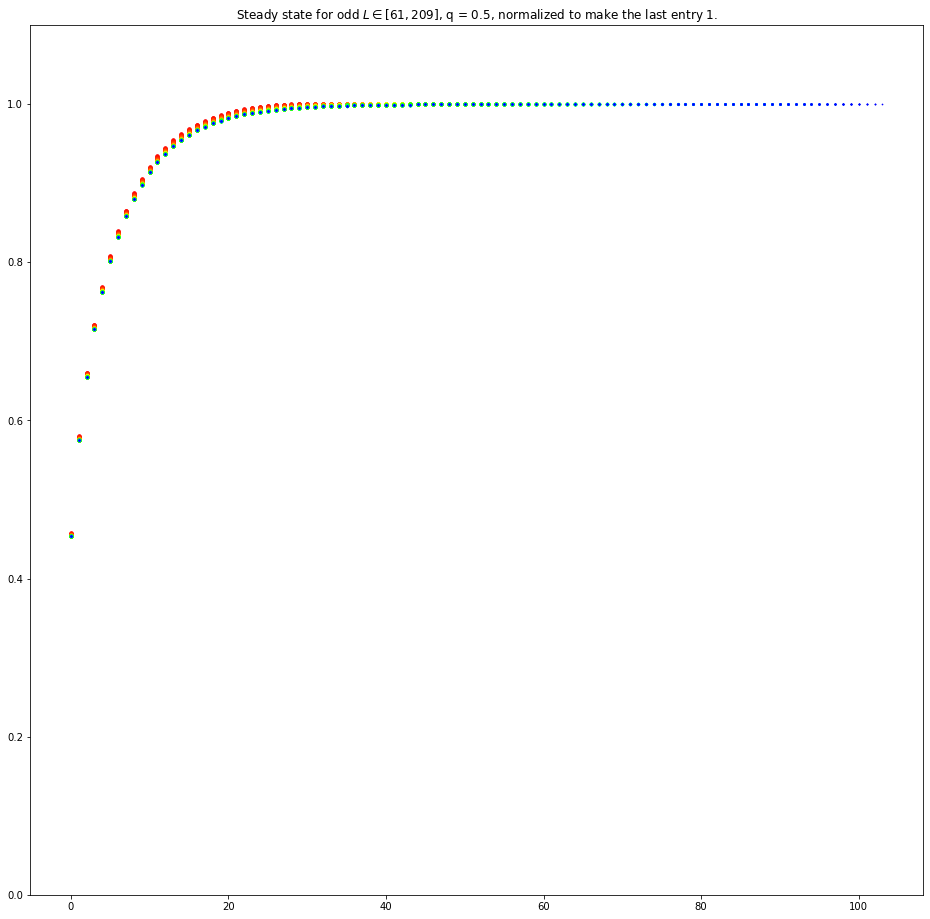

In [169]:
def rainbows(t):
    t *= 2
    if t < 0.5:
        return (1, 2*t, 0)
    elif t < 1:
        return (2*(1-t), 1, 0)
    elif t < 1.5:
        return (0, 1, 2*(t-1))
    elif t < 2:
        return (0, 2*(2-t), 1)
    elif t < 2.5:
        return (2*(t-2), 0, 1)
    elif t <= 3:
        return (1, 0, 2*(3-t))

def make_plot():
    p.figure(figsize=(16, 16))
    p.ylim([0, 1.1])
    p.title("Steady state for odd $L \\in [61, 209]$, q = 0.5, normalized to make the last entry 1.")
    for L in STEADYSTATES:
        t = (L - 61) / (209 - 61)
        z = STEADYSTATES[L]
        p.scatter(np.arange(z.shape[0]), z, s = 0.5 + 12 * (1 - t), color = rainbows(t))
    p.show()

make_plot()

It's difficult to see the convergence for individual entries from that graph, so we plot some of them.

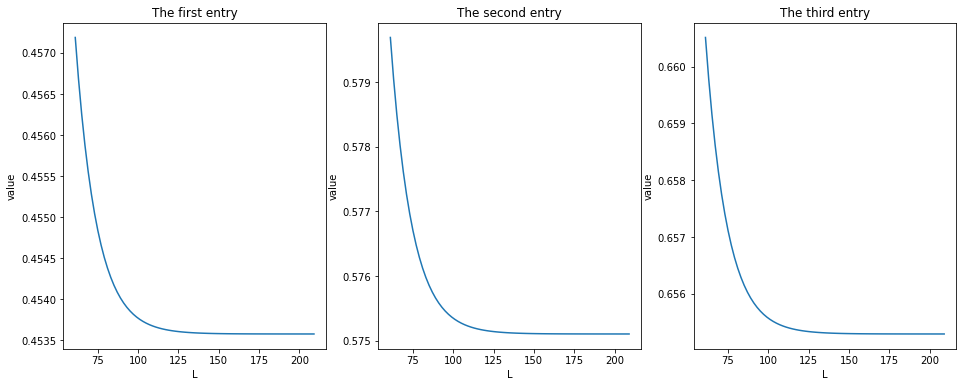

In [183]:
steady_indices = list(STEADYSTATES.keys())
steady_entry = lambda j: [z[j] for z in STEADYSTATES.values()]
steady_first, steady_second, steady_third = [steady_entry(j) for j in [0, 1, 2]]

def make_plot(p, x, y, z):
    p.set_title("The " + z + " entry")
    p.set_xlabel("L")
    p.set_ylabel("value")
    p.plot(x, y)
    
fig, (a, b, c) = p.subplots(1, 3, figsize=(16, 6))
make_plot(a, steady_indices, steady_first, "first")
make_plot(b, steady_indices, steady_second, "second")
make_plot(c, steady_indices, steady_third, "third")
p.show()

How fast is this exponential decay?

steady[0] estimate is: 0.355864 * exp(-0.075252 * x) + 0.453577
steady[1] estimate is: 0.451921 * exp(-0.075270 * x) + 0.575107
steady[2] estimate is: 0.515458 * exp(-0.075282 * x) + 0.655292


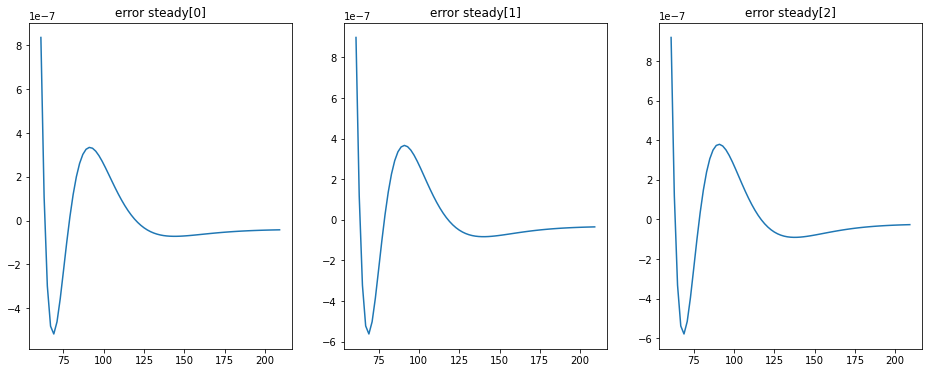

In [217]:
def EXPONENTIAL_CURVE_FIT(x, y):
    def guess(x, a, b, c):
        return b * np.exp(-a*x) + c
    import scipy.optimize
    start = 0
    z = (0.01, 1, 1)
    a, b, c = sp.optimize.curve_fit(guess, x, y, p0=z)[0]
    return (a, b, c), guess(np.array(x), a, b, c)

def EXPONENTIAL_FIT_PLO(namely, p, x, y):
    (a, b, c), estimate = EXPONENTIAL_CURVE_FIT(x, y)
    print(namely + " estimate is: %f * exp(%f * x) %s %f" % (b, -a, "-" if c < 0 else "+", abs(c)))
    p.set_title("error %s"%namely)
    p.plot(x, estimate - y)
    
fig, (a, b, c) = p.subplots(1, 3, figsize=(16, 6))
EXPONENTIAL_FIT_PLO("steady[0]", a, steady_indices, steady_first)
EXPONENTIAL_FIT_PLO("steady[1]", b, steady_indices, steady_second)
EXPONENTIAL_FIT_PLO("steady[2]", c, steady_indices, steady_third)

In [202]:
np.exp(-0.075270 * 2)

0.8602433195864259

In [197]:
1 - np.exp(-2)

0.8646647167633873

In [194]:
def f(L, stopprob):
    graph = activatedwalk(L, stopprob)
    matrix = graphmatrix(graph)
    tmat = matrix.calculate_sink_transition_matrix()
    for j in range(tmat.shape[0]):
        tmat[j, :] /= np.sum(tmat[j, :])
    steady = sp.linalg.null_space(tmat.transpose() - np.eye(tmat.shape[0]), rcond=1e-4)
    if steady.shape[1] != 1:
        print("steady not found:", steady)
    output = np.zeros(L + 1)
    for j in range(steady.shape[0]):
        output[j + 1] += 0.5 * steady[j]
        output[L - 1 - j] += 0.5 * steady[j]
    return output / output[L//2]
